In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))

Using device: cuda
GPU: Tesla T4


In [3]:
import numpy as np
import os

DATA_DIR = "/content/drive/MyDrive/dl_project/data_processed_pre_covid"

X_train = np.load(os.path.join(DATA_DIR, "X_train_ws24.npy"))
y_train = np.load(os.path.join(DATA_DIR, "y_train_ws24.npy"))

X_val = np.load(os.path.join(DATA_DIR, "X_val_ws24.npy"))
y_val = np.load(os.path.join(DATA_DIR, "y_val_ws24.npy"))

X_test = np.load(os.path.join(DATA_DIR, "X_test_ws24.npy"))
y_test = np.load(os.path.join(DATA_DIR, "y_test_ws24.npy"))

print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape, y_val.shape)
print("Test: ", X_test.shape, y_test.shape)


Train: (125781, 24, 66) (125781,)
Val:   (26953, 24, 66) (26953,)
Test:  (26954, 24, 66) (26954,)


In [4]:
from sklearn.preprocessing import StandardScaler

# Normalize features
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val_scaled = scaler_X.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
X_test_scaled = scaler_X.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# Normalize targets
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).ravel()

# Convert to tensors
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train_scaled, dtype=torch.float32).to(device)

X_val_t = torch.tensor(X_val_scaled, dtype=torch.float32).to(device)
y_val_t = torch.tensor(y_val_scaled, dtype=torch.float32).to(device)

X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_test_t = torch.tensor(y_test_scaled, dtype=torch.float32).to(device)

In [5]:
from torch.utils.data import TensorDataset, DataLoader

BATCH_SIZE = 64

train_loader = DataLoader(
    TensorDataset(X_train_t, y_train_t),
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_loader = DataLoader(
    TensorDataset(X_val_t, y_val_t),
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_loader = DataLoader(
    TensorDataset(X_test_t, y_test_t),
    batch_size=BATCH_SIZE,
    shuffle=False
)


In [6]:
xb, yb = next(iter(train_loader))
print("Batch X:", xb.shape)
print("Batch y:", yb.shape)


Batch X: torch.Size([64, 24, 66])
Batch y: torch.Size([64])


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class ResidualTCNBlock(nn.Module):
    def __init__(self, channels, kernel_size=3, dilation=1, dropout=0.2):
        super().__init__()

        padding = (kernel_size - 1) * dilation // 2

        self.conv1 = nn.Conv1d(
            channels, channels,
            kernel_size=kernel_size,
            padding=padding,
            dilation=dilation
        )

        self.conv2 = nn.Conv1d(
            channels, channels,
            kernel_size=kernel_size,
            padding=padding,
            dilation=dilation
        )

        self.dropout = nn.Dropout(dropout)
        self.norm = nn.BatchNorm1d(channels)

    def forward(self, x):
        residual = x

        x = F.relu(self.conv1(x))
        x = self.dropout(x)

        x = self.conv2(x)
        x = self.norm(x)

        return F.relu(x + residual)


In [8]:
class TimesNet_TCN(nn.Module):
    def __init__(
        self,
        num_features,
        hidden_channels=64,
        kernel_size=3,
        dilations=(1, 2, 4),
        dropout=0.2
    ):
        super().__init__()

        self.input_conv = nn.Conv1d(
            in_channels=num_features,
            out_channels=hidden_channels,
            kernel_size=kernel_size,
            padding=kernel_size // 2
        )

        self.tcn_blocks = nn.ModuleList([
            ResidualTCNBlock(
                channels=hidden_channels,
                kernel_size=kernel_size,
                dilation=d,
                dropout=dropout
            )
            for d in dilations
        ])

        self.fc = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_channels // 2, 1)
        )

    def forward(self, x):
        # x: (B, T, F)
        x = x.transpose(1, 2)              # (B, F, T)
        x = self.input_conv(x)             # (B, C, T)

        for block in self.tcn_blocks:
            x = block(x)

        x = x.mean(dim=-1)                 # (B, C)

        return self.fc(x).squeeze(-1)


In [9]:
model = TimesNet_TCN(
    num_features=X_train.shape[2],
    hidden_channels=64
).to(device)

criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [10]:
import torch

def mae(y_true, y_pred):
    return torch.mean(torch.abs(y_true - y_pred))

def rmse(y_true, y_pred):
    return torch.sqrt(torch.mean((y_true - y_pred) ** 2))

def mape(y_true, y_pred, eps=1e-6):
    return torch.mean(torch.abs((y_true - y_pred) / (y_true + eps))) * 100


In [11]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
import copy


In [12]:
def train_model(
    model,
    train_loader,
    val_loader,
    epochs=50,
    lr=1e-3,
    patience=15
):
    criterion = torch.nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(
        optimizer,
        mode="min",
        factor=0.5,
        patience=3,

    )

    best_val_mae = float("inf")
    best_state = None
    patience_counter = 0

    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0.0

        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * xb.size(0)

        train_loss /= len(train_loader.dataset)

        model.eval()
        val_mae = 0.0

        with torch.no_grad():
            for xb, yb in val_loader:
                preds = model(xb)
                val_mae += mae(yb, preds).item() * xb.size(0)

        val_mae /= len(val_loader.dataset)
        scheduler.step(val_mae)

        print(
            f"Epoch {epoch:03d} | "
            f"Train MSE: {train_loss:.4f} | "
            f"Val MAE: {val_mae:.4f}"
        )

        if val_mae < best_val_mae:
            best_val_mae = val_mae
            best_state = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    model.load_state_dict(best_state)
    return model


In [13]:
def evaluate_model(model, test_loader, scaler_y):
    model.eval()

    y_true_all = []
    y_pred_all = []

    with torch.no_grad():
        for xb, yb in test_loader:
            preds = model(xb)
            y_true_all.append(yb.cpu())
            y_pred_all.append(preds.cpu())

    y_true_scaled = torch.cat(y_true_all).numpy()
    y_pred_scaled = torch.cat(y_pred_all).numpy()

    y_true = scaler_y.inverse_transform(y_true_scaled.reshape(-1, 1)).ravel()
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

    y_true_t = torch.tensor(y_true)
    y_pred_t = torch.tensor(y_pred)

    return {
        "MAPE": mape(y_true_t, y_pred_t).item(),
        "MAE": mae(y_true_t, y_pred_t).item(),
        "RMSE": rmse(y_true_t, y_pred_t).item()
    }

In [14]:
model = TimesNet_TCN(
    num_features=X_train.shape[2],
    hidden_channels=64,
    dropout=0.2
).to(device)

model = train_model(
    model,
    train_loader,
    val_loader,
    epochs=50,
    lr=1e-3,
    patience=7
)

test_metrics = evaluate_model(model, test_loader, scaler_y)
print("Test Metrics:", test_metrics)

Epoch 001 | Train MSE: 0.1908 | Val MAE: 0.1472
Epoch 002 | Train MSE: 0.1529 | Val MAE: 0.1235
Epoch 003 | Train MSE: 0.1425 | Val MAE: 0.1319
Epoch 004 | Train MSE: 0.1369 | Val MAE: 0.1224
Epoch 005 | Train MSE: 0.1339 | Val MAE: 0.1158
Epoch 006 | Train MSE: 0.1307 | Val MAE: 0.1166
Epoch 007 | Train MSE: 0.1279 | Val MAE: 0.1226
Epoch 008 | Train MSE: 0.1257 | Val MAE: 0.1184
Epoch 009 | Train MSE: 0.1242 | Val MAE: 0.1207
Epoch 010 | Train MSE: 0.1177 | Val MAE: 0.1161
Epoch 011 | Train MSE: 0.1161 | Val MAE: 0.1176
Epoch 012 | Train MSE: 0.1150 | Val MAE: 0.1208
Early stopping triggered.
Test Metrics: {'MAPE': 1.9174420833587646, 'MAE': 95.29193878173828, 'RMSE': 127.10493469238281}


In [15]:
import os
import torch

MODEL_DIR = "/content/drive/MyDrive/dl_project/models"
os.makedirs(MODEL_DIR, exist_ok=True)

MODEL_PATH = os.path.join(MODEL_DIR, "timesnet_tcn_ws24.pt")

torch.save({
    "model_state_dict": model.state_dict(),
    "window_size": 24,
    "num_features": X_train.shape[2],
    "architecture": "TimesNet-TCN-inspired",
}, MODEL_PATH)

print("Model saved to:", MODEL_PATH)

Model saved to: /content/drive/MyDrive/dl_project/models/timesnet_tcn_ws24.pt


In [16]:
model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for xb, yb in test_loader:
        preds = model(xb)
        y_true.append(yb.cpu())
        y_pred.append(preds.cpu())

y_true_scaled = torch.cat(y_true).numpy()
y_pred_scaled = torch.cat(y_pred).numpy()

y_true = scaler_y.inverse_transform(y_true_scaled.reshape(-1, 1)).ravel()
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

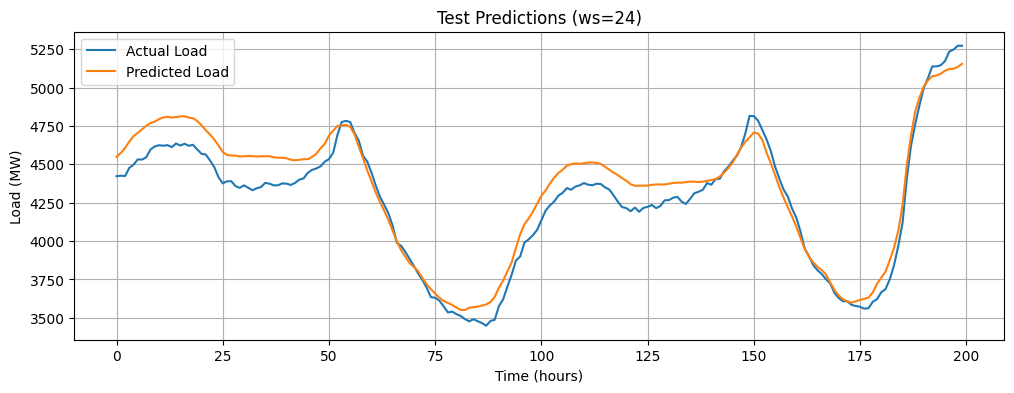

In [17]:
import matplotlib.pyplot as plt

N = 200

plt.figure(figsize=(12, 4))
plt.plot(y_true[:N], label="Actual Load")
plt.plot(y_pred[:N], label="Predicted Load")
plt.title("Test Predictions (ws=24)")
plt.xlabel("Time (hours)")
plt.ylabel("Load (MW)")
plt.legend()
plt.grid(True)
plt.show()


In [18]:
def build_sliding_windows_with_time(df, feature_cols, target_col, time_col, window_size):
    X, y, t = [], [], []

    df = df.sort_values(time_col).reset_index(drop=True)
    Xv = df[feature_cols].values
    yv = df[target_col].values
    tv = df[time_col].values

    for i in range(len(df) - window_size):
        X.append(Xv[i:i+window_size])
        y.append(yv[i+window_size])
        t.append(tv[i+window_size])

    return np.array(X), np.array(y), np.array(t)

In [19]:
import pandas as pd
from sklearn.metrics import r2_score

y_test = pd.Series(y_true)
y_test_pred = pd.Series(y_pred)

test_r2 = r2_score(y_test, y_test_pred)

start_datetime = pd.Timestamp("2019-01-01", tz="UTC")

df_viz = pd.DataFrame({
    "datetime": pd.date_range(
        start=start_datetime,
        periods=len(y_test),
        freq="h"
    ),
    "Actual": y_test.values,
    "Predicted": y_test_pred.values
})

df_viz["Hour"] = df_viz["datetime"].dt.hour
df_viz["IsWeekend"] = df_viz["datetime"].dt.dayofweek >= 5
df_viz["Month"] = df_viz["datetime"].dt.month

def season_map(m):
    if m in [12, 1, 2]: return "Winter"
    if m in [3, 4, 5]: return "Spring"
    if m in [6, 7, 8]: return "Summer"
    return "Autumn"

df_viz["Season"] = df_viz["Month"].apply(season_map)

print("df_viz ready:", df_viz.head())

df_viz ready:                    datetime       Actual    Predicted  Hour  IsWeekend  Month  \
0 2019-01-01 00:00:00+00:00  4422.700195  4548.152344     0      False      1   
1 2019-01-01 01:00:00+00:00  4425.850098  4573.714844     1      False      1   
2 2019-01-01 02:00:00+00:00  4423.629883  4606.726562     2      False      1   
3 2019-01-01 03:00:00+00:00  4476.540039  4647.959961     3      False      1   
4 2019-01-01 04:00:00+00:00  4497.810059  4683.500488     4      False      1   

   Season  
0  Winter  
1  Winter  
2  Winter  
3  Winter  
4  Winter  


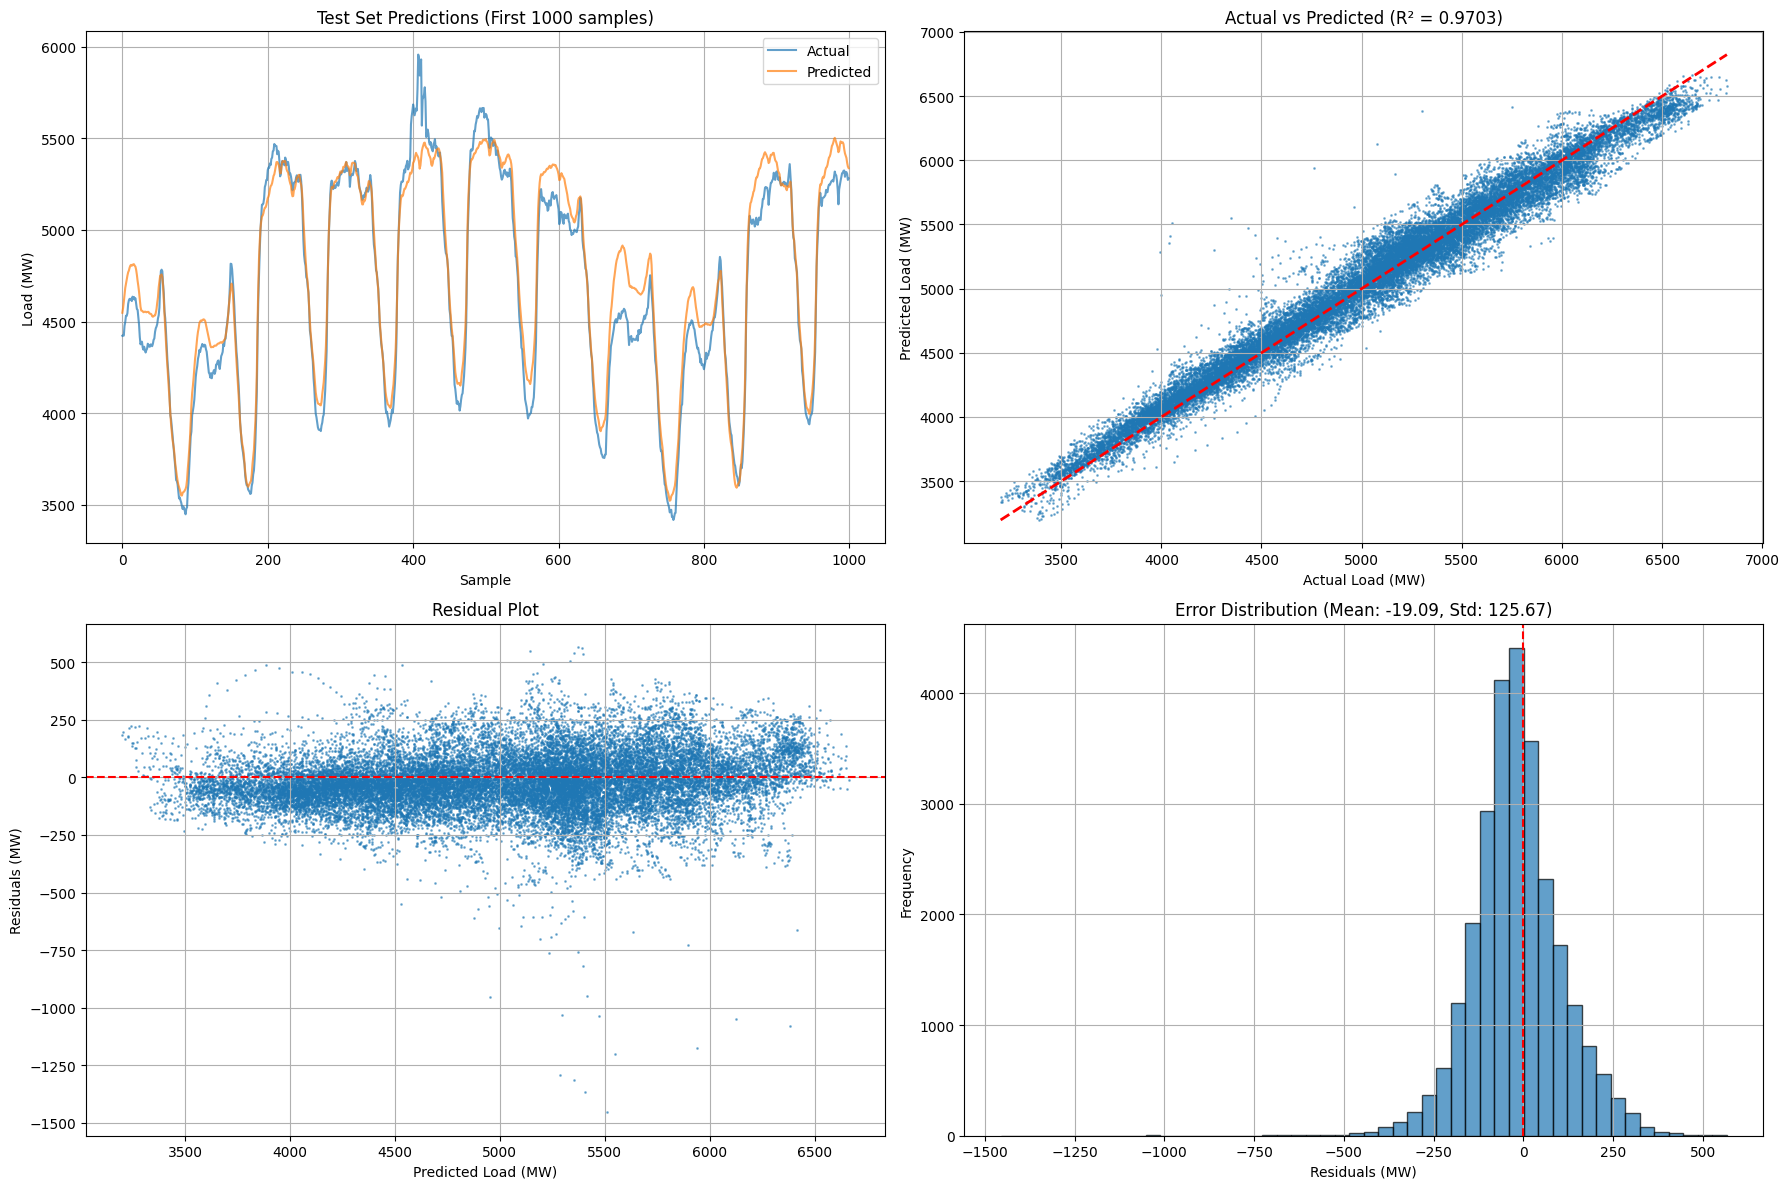

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

sample_size = min(1000, len(y_test))
axes[0, 0].plot(y_test.values[:sample_size], label='Actual', alpha=0.7)
axes[0, 0].plot(y_test_pred.values[:sample_size], label='Predicted', alpha=0.7)
axes[0, 0].set_title(f'Test Set Predictions (First {sample_size} samples)')
axes[0, 0].set_xlabel('Sample')
axes[0, 0].set_ylabel('Load (MW)')
axes[0, 0].legend()
axes[0, 0].grid(True)

axes[0, 1].scatter(y_test, y_test_pred, alpha=0.5, s=1)
axes[0, 1].plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    'r--', lw=2
)
axes[0, 1].set_xlabel('Actual Load (MW)')
axes[0, 1].set_ylabel('Predicted Load (MW)')
axes[0, 1].set_title(f'Actual vs Predicted (R² = {test_r2:.4f})')
axes[0, 1].grid(True)

residuals = y_test - y_test_pred
axes[1, 0].scatter(y_test_pred, residuals, alpha=0.5, s=1)
axes[1, 0].axhline(y=0, color='r', linestyle='--')
axes[1, 0].set_xlabel('Predicted Load (MW)')
axes[1, 0].set_ylabel('Residuals (MW)')
axes[1, 0].set_title('Residual Plot')
axes[1, 0].grid(True)

axes[1, 1].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1, 1].axvline(x=0, color='r', linestyle='--')
axes[1, 1].set_xlabel('Residuals (MW)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title(
    f'Error Distribution (Mean: {residuals.mean():.2f}, Std: {residuals.std():.2f})'
)
axes[1, 1].grid(True)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/dl_project/results/plots/test_predictions.png', dpi=300)
plt.show()


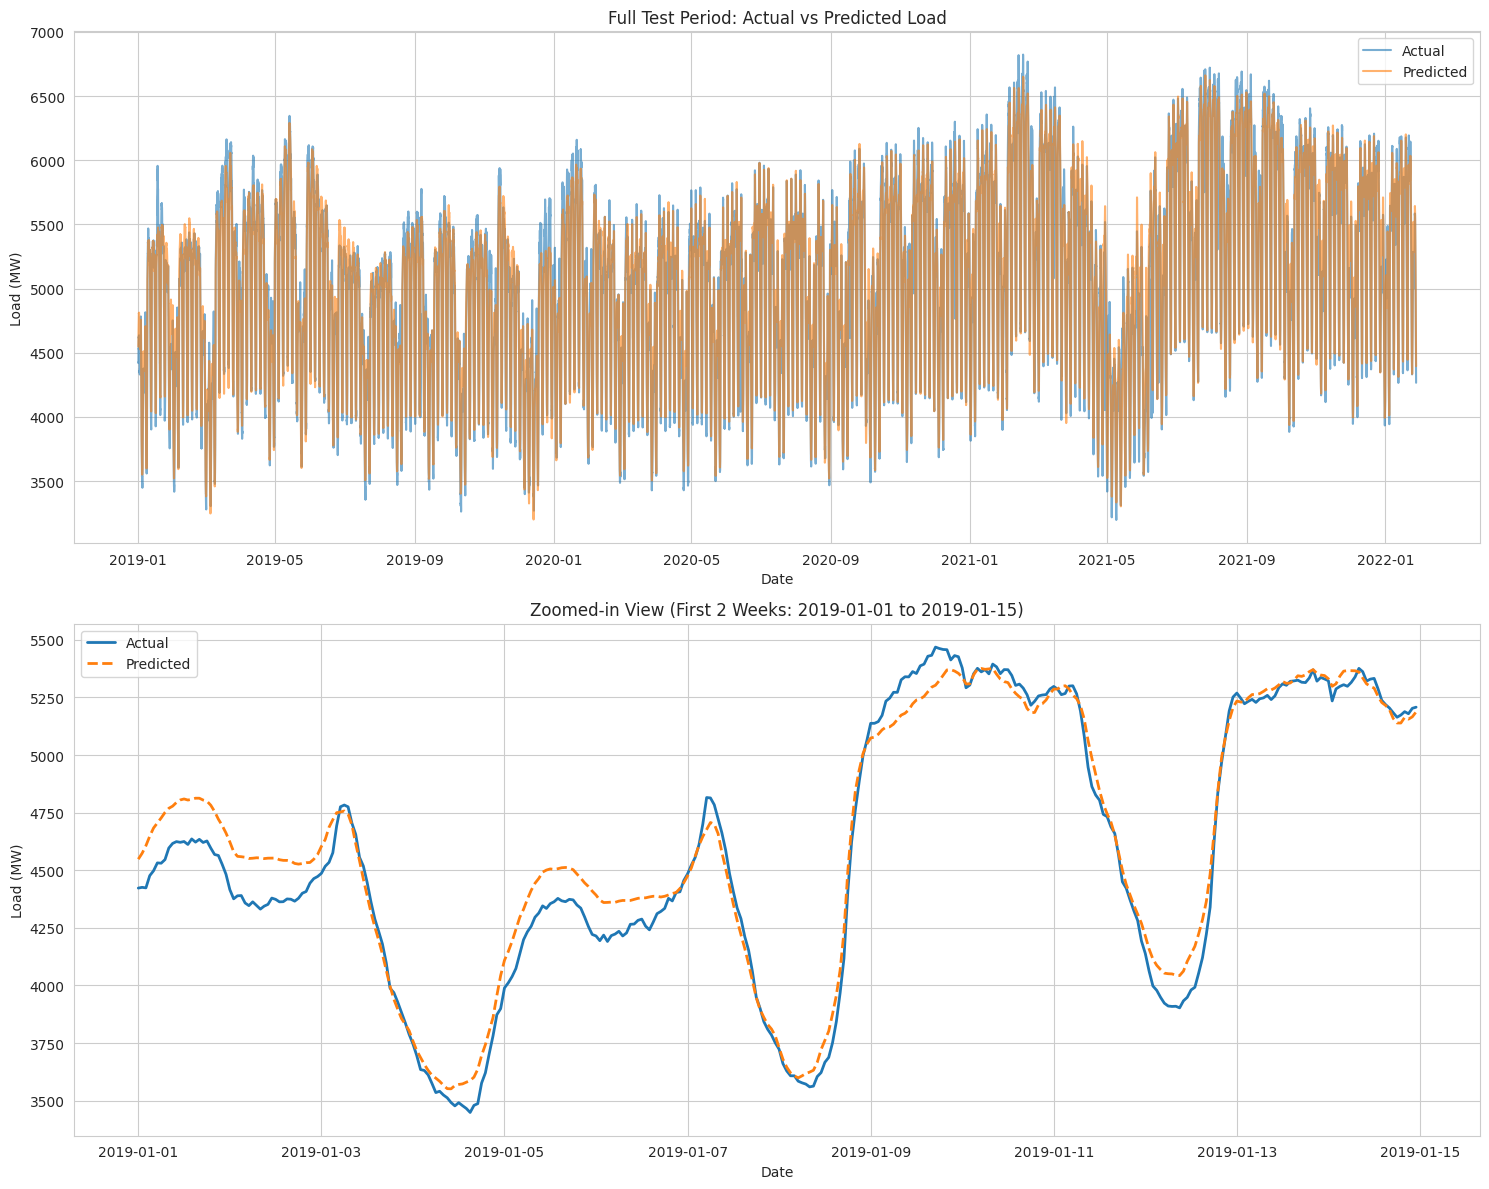

In [21]:
import seaborn as sns
sns.set_style("whitegrid")

fig, axes = plt.subplots(2, 1, figsize=(15, 12))

axes[0].plot(df_viz['datetime'], df_viz['Actual'], label='Actual', alpha=0.6)
axes[0].plot(df_viz['datetime'], df_viz['Predicted'], label='Predicted', alpha=0.6)
axes[0].set_title('Full Test Period: Actual vs Predicted Load')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Load (MW)')
axes[0].legend()
axes[0].grid(True)

zoom_start = df_viz['datetime'].min()
zoom_end = zoom_start + pd.Timedelta(days=14)
df_zoom = df_viz[
    (df_viz['datetime'] >= zoom_start) &
    (df_viz['datetime'] < zoom_end)
]

axes[1].plot(df_zoom['datetime'], df_zoom['Actual'], label='Actual', linewidth=2)
axes[1].plot(df_zoom['datetime'], df_zoom['Predicted'], label='Predicted', linestyle='--', linewidth=2)
axes[1].set_title(
    f'Zoomed-in View (First 2 Weeks: {zoom_start.date()} to {zoom_end.date()})'
)
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Load (MW)')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/dl_project/results/plots/time_series_comparison.png', dpi=300)
plt.show()


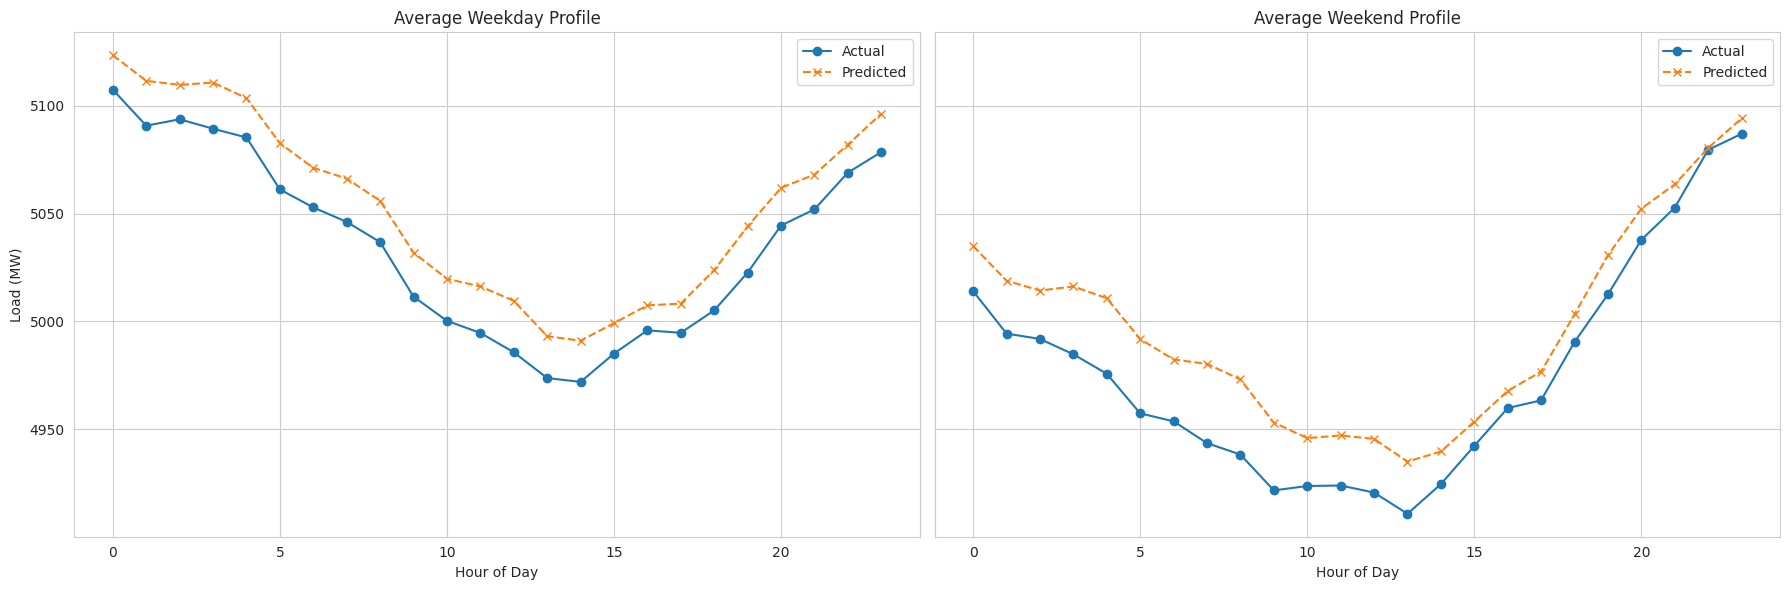

In [22]:
weekday_df = df_viz[~df_viz['IsWeekend']]
weekend_df = df_viz[df_viz['IsWeekend']]

weekday_hourly = weekday_df.groupby('Hour')[['Actual', 'Predicted']].mean()
weekend_hourly = weekend_df.groupby('Hour')[['Actual', 'Predicted']].mean()

fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

axes[0].plot(weekday_hourly.index, weekday_hourly['Actual'], marker='o', label='Actual')
axes[0].plot(weekday_hourly.index, weekday_hourly['Predicted'], marker='x', linestyle='--', label='Predicted')
axes[0].set_title('Average Weekday Profile')
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Load (MW)')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(weekend_hourly.index, weekend_hourly['Actual'], marker='o', label='Actual')
axes[1].plot(weekend_hourly.index, weekend_hourly['Predicted'], marker='x', linestyle='--', label='Predicted')
axes[1].set_title('Average Weekend Profile')
axes[1].set_xlabel('Hour of Day')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/dl_project/results/plots/weekday_weekend_profiles.png', dpi=300)
plt.show()
